In [1]:
import re
import operator
import warnings
import pandas as pd
import seaborn as sns
from string import digits
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,precision_score,recall_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
#read_dataset
dataframe=pd.read_csv("data/spam.csv",encoding='latin-1')
len(dataframe)

5572

In [3]:
dataframe.head()


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#v1 -> lablel :    ham=0 spam=1
#v2 -> Message :   text message

dataframe=dataframe[["v2","v1"]]
dataframe.columns=["Message","Label"]

#binary encode
dataframe["Label"]=dataframe["Label"].apply(lambda x: 1 if x=="spam" else 0)

#dataframe
dataframe.head()

,Message,Label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [5]:
dataframe["Message Length"]=dataframe["Message"].apply(lambda x: len(x))

In [6]:
# Average length of spam message & ham message:
average_length=dataframe[["Message Length","Label"]].groupby(["Label"],as_index=False).median()
average_length["Label"]=average_length["Label"].map({0:"Non-Spam",1:"Spam"})
average_length.columns=["Label","Median Message Length"]
average_length["Median Message Length"]=average_length["Median Message Length"].round(2)
average_length 

,Label,Median Message Length
0,Non-Spam,52
1,Spam,150


In [7]:
# Contains digit
dataframe["Contain Digit"]=dataframe["Message"].apply(lambda x: True if any(i.isdigit() for i in x) else False)
contain_digit=dataframe[["Contain Digit","Label"]].groupby(["Label"],as_index=False).sum()
contain_digit["Label"]=contain_digit["Label"].map({0:"Non-Spam",1:"Spam"})
total={"Spam":747,"Non-Spam": 4825}

def composition(x):
    return str(round((x["Contain Digit"]/total[x["Label"]])*100,2))+"%"

contain_digit["Contain Digit"]=contain_digit[["Label","Contain Digit"]].apply(lambda x: composition(x), axis=1)

contain_digit.columns=["Label","Contains Digit Composition (%)"]

contain_digit
average_length.set_index("Label").join(contain_digit.set_index("Label"),on="Label",how="inner").reset_index()

,Label,Median Message Length,Contains Digit Composition (%)
0,Non-Spam,52,15.5%
1,Spam,150,94.78%


In [8]:
average_length

,Label,Median Message Length
0,Non-Spam,52
1,Spam,150


In [9]:
def process_message_text(dataframe):
    
    #lower text message
    dataframe["Clean_Message_Text"]=dataframe["Message"].apply(lambda x: x.lower() )
    
    # Punctuation removal
    dataframe["Clean_Message_Text"]=dataframe["Clean_Message_Text"].apply(lambda x: re.sub(r'[^\w\s]', ' ', x) )

    #remove digits
    remove_digits = str.maketrans('', '', digits)
    dataframe["Clean_Message_Text"]=dataframe["Clean_Message_Text"].apply(lambda x:  x.translate(remove_digits))
    
    #tokenize words
    dataframe["Clean_Message_Text"]=dataframe["Clean_Message_Text"].apply(lambda x: word_tokenize(x))
    
    #remove stop words
    dataframe["Clean_Message_Text"]=dataframe["Clean_Message_Text"].apply(lambda x: [y for y in x if y not in stopwords.words('english')])
   
    #remove single letter
    dataframe["Clean_Message_Text"]=dataframe["Clean_Message_Text"].apply(lambda x: [y for y in x if len(y)!=1])
    
    #restructure into sentence
    dataframe["Clean_Message_Text"]=dataframe["Clean_Message_Text"].apply(lambda x: (' ').join(x))
    
    return dataframe[["Clean_Message_Text","Label"]]

In [10]:
clean_dataframe=process_message_text(dataframe)

#spam data
spam_dataframe=clean_dataframe[clean_dataframe["Label"]==1] # 747 data points

#non spam data
nonspam_dataframe=clean_dataframe[clean_dataframe["Label"]==0]  # 4825 data points

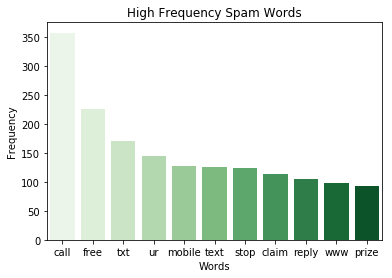

In [11]:
#spam dataframe
spam_words_distribution=pd.DataFrame(spam_dataframe["Clean_Message_Text"].str.split(expand=True).stack().value_counts()).reset_index()
spam_words_distribution.columns=["Words","Frequency"]
sns.barplot(x="Words",y="Frequency",data=spam_words_distribution[:11],palette="Greens")
plt.title("High Frequency Spam Words")
plt.show()

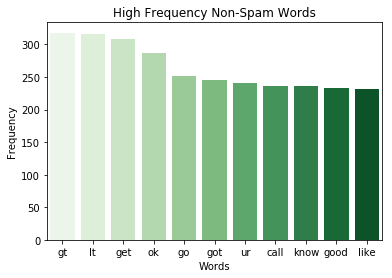

In [12]:
#nonspam dataframe
nonspam_words_distribution=pd.DataFrame(nonspam_dataframe["Clean_Message_Text"].str.split(expand=True).stack().value_counts()).reset_index()
nonspam_words_distribution.columns=["Words","Frequency"]
sns.barplot(x="Words",y="Frequency",data=nonspam_words_distribution[:11],palette="Greens")
plt.title("High Frequency Non-Spam Words")
plt.show()

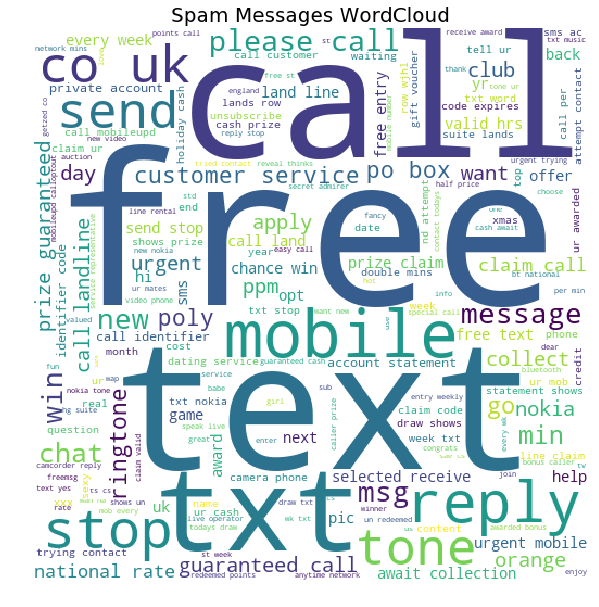

In [13]:
spam_words = ' '.join(list(spam_dataframe['Clean_Message_Text']))
spam_word_cloud = WordCloud(width = 512,height = 512,background_color='white').generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'white')
plt.imshow(spam_word_cloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title("Spam Messages WordCloud", fontsize=20)
plt.show()

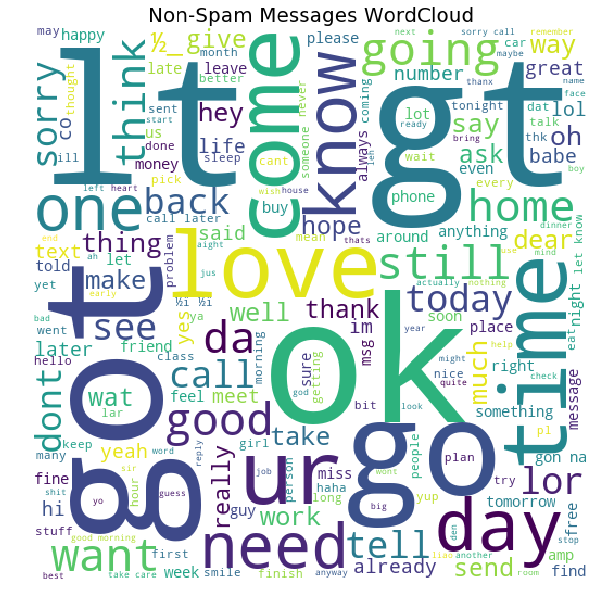

In [14]:
#non spam word cloud
spam_words = ' '.join(list(nonspam_dataframe['Clean_Message_Text']))
spam_word_cloud = WordCloud(width = 512,height = 512,background_color='white').generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'white')
plt.imshow(spam_word_cloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title("Non-Spam Messages WordCloud", fontsize=20)
plt.show()

In [15]:
#spam data
spam_dataframe=dataframe[dataframe["Label"]==1] # 747 data points

#non spam data
nonspam_dataframe=dataframe[dataframe["Label"]==0]  # 4825 data points

[]

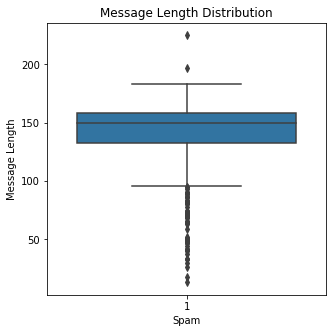

In [16]:
plt.figure(figsize=(5,5))
sns.boxplot(x="Label", y="Message Length",hue="Label",data=spam_dataframe) #box plot
plt.title("Message Length Distribution")
plt.xlabel("Spam")
plt.legend().set_visible(False)
plt.ylabel("Message Length")
plt.plot()

[]

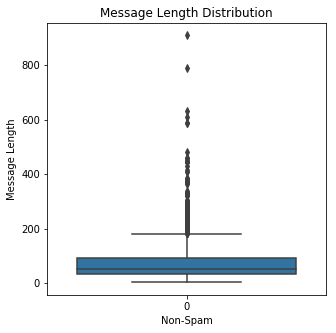

In [17]:
plt.figure(figsize=(5,5))
sns.boxplot(x="Label", y="Message Length",hue="Label",data=nonspam_dataframe) #box plot
plt.title("Message Length Distribution")
plt.xlabel("Non-Spam")
plt.legend().set_visible(False)
plt.ylabel("Message Length")
plt.plot()

In [18]:
def models(X_train, X_test, y_train, y_test,model):
    if model=="LR":
        print("Logistic Regression Model")
        ml_model=LogisticRegression(random_state=42,solver='liblinear',n_jobs=-1)
        ml_model.fit(X_train,y_train)
        print("Training Accuracy: ",round(f1_score(ml_model.predict(X_train),y_train),3))
        print("Test Accuracy: ",round(f1_score(ml_model.predict(X_test),y_test),3))
        return [round(f1_score(ml_model.predict(X_train),y_train),3),round(f1_score(ml_model.predict(X_test),y_test),3)]
        
    if model=="NB":
        print("Naive Bayes")
        ml_model=GaussianNB()
        ml_model.fit(X_train,y_train)
        print("Training Accuracy: ",round(f1_score(ml_model.predict(X_train),y_train),3))
        print("Test Accuracy: ",round(f1_score(ml_model.predict(X_test),y_test),3))
        return [round(f1_score(ml_model.predict(X_train),y_train),3),round(f1_score(ml_model.predict(X_test),y_test),3)]

In [19]:
def train_test(dataframe_matrix,labels,size):
    X_train, X_test, y_train, y_test = train_test_split(dataframe_matrix,labels, test_size=size,random_state=42)
    return X_train, X_test, y_train, y_test

In [20]:
def method(dataframe,sel_method="BagOfWords"):
    if sel_method=="BagOfWords":
        print("Method: Bag of Words")
        vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
        dataframe_matrix = vectorizer.fit_transform(dataframe["Clean_Message_Text"])
        return dataframe_matrix.toarray(),dataframe["Label"]
    
    if sel_method=="TF-IDF":
        print("Method: TF-IDF")
        vectorizer = TfidfVectorizer(analyzer='word', ngram_range = (1,1))
        dataframe_matrix = vectorizer.fit_transform(dataframe['Clean_Message_Text'])
        return dataframe_matrix.toarray(),dataframe["Label"]

    


In [21]:
model_performance=[]
dataframe_matrix,labels=method(clean_dataframe)
X_train, X_test, y_train, y_test=train_test(dataframe_matrix,labels,0.30)
model_performance.append(["BOW+LR"]+models(X_train, X_test, y_train,y_test,model="LR"))
model_performance.append(["BOW+NB"]+models(X_train, X_test, y_train,y_test,model="NB"))

dataframe_matrix,labels=method(clean_dataframe,sel_method="TF-IDF")
X_train, X_test, y_train, y_test=train_test(dataframe_matrix,labels,0.30)
model_performance.append(["TF-IDF+LR"]+models(X_train, X_test, y_train,y_test,model="LR"))
model_performance.append(["TF-IDF+NB"]+models(X_train, X_test, y_train,y_test,model="NB"))



Method: Bag of Words
Logistic Regression Model
Training Accuracy:  0.988
Test Accuracy:  0.903
Naive Bayes
Training Accuracy:  0.836
Test Accuracy:  0.676
Method: TF-IDF
Logistic Regression Model
Training Accuracy:  0.879
Test Accuracy:  0.77
Naive Bayes
Training Accuracy:  0.836
Test Accuracy:  0.655


In [22]:
model_performance=pd.DataFrame(model_performance,columns=["Approach","Train F1 score","Test F1 score"])

In [23]:
model_performance

,Approach,Train F1 score,Test F1 score
0,BOW+LR,0.988,0.903
1,BOW+NB,0.836,0.676
2,TF-IDF+LR,0.879,0.770
3,TF-IDF+NB,0.836,0.655


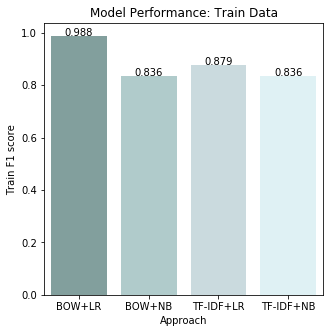

In [24]:
plt.figure(figsize=(5,5))
bar_plot=sns.barplot(x="Approach",y="Train F1 score",data=model_performance,palette=["#7DA4A1","#ABCFCF","#C6DCE2","#DBF4F8"])
plt.title("Model Performance: Train Data")

for index, row in model_performance.iterrows():
    bar_plot.text(index, row["Train F1 score"],row["Train F1 score"], color='black', ha="center")
plt.show()



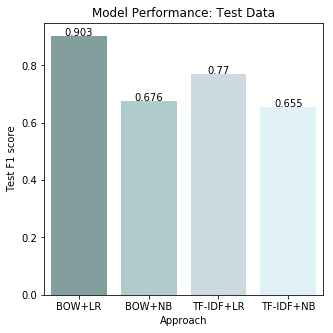

In [25]:
plt.figure(figsize=(5,5))
bar_plot=sns.barplot(x="Approach",y="Test F1 score",data=model_performance,palette=["#7DA4A1","#ABCFCF","#C6DCE2","#DBF4F8"])
plt.title("Model Performance: Test Data")

for index, row in model_performance.iterrows():
    bar_plot.text(index, row["Test F1 score"],row["Test F1 score"], color='black', ha="center")
plt.show()




In [26]:
#logistic regression performs well both on test and train data
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
dataframe_matrix = vectorizer.fit_transform(dataframe["Clean_Message_Text"])
dataframe_matrix=dataframe_matrix.toarray()
labels=dataframe["Label"]
X_train, X_test, y_train, y_test=train_test(dataframe_matrix,labels,0.30)
ml_model=LogisticRegression(random_state=42,solver='liblinear',n_jobs=-1)
ml_model.fit(X_train,y_train)
print("Test Accuracy: ",round(f1_score(ml_model.predict(X_test),y_test),3))

Test Accuracy:  0.903


In [27]:
def plot_heatmap(cm,title):
    df_cm2 = pd.DataFrame(cm, index = ['Non Spam', 'spam'])
    df_cm2.columns=['Non Spam','spam']
    ax = plt.axes()
    sns.heatmap(df_cm2, annot=True, fmt="d", linewidths=.5,ax=ax,cmap="Greens")
    ax.set_title(title)
    plt.show()

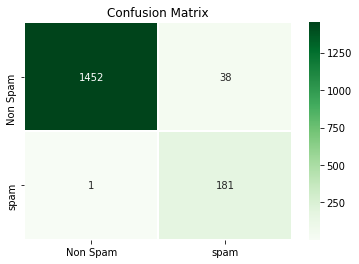

In [28]:
plot_heatmap(confusion_matrix(ml_model.predict(X_test),y_test),"Confusion Matrix")

In [29]:
print("Precision Score: ",precision_score(ml_model.predict(X_test),y_test))

Precision Score:  0.8264840182648402


In [30]:
print("Recall Score: ",recall_score(ml_model.predict(X_test),y_test))


Recall Score:  0.9945054945054945


In [31]:
print("F1 Score: ",f1_score(ml_model.predict(X_test),y_test))



F1 Score:  0.9027431421446385


In [32]:
#Model Coefficients
model_coefficient=pd.DataFrame(ml_model.coef_,columns=[x[0] for x in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]).transpose().sort_values(0,ascending=False).reset_index()
model_coefficient.columns=["Word","Model Coeff"]
model_coefficient.head(30)

,Word,Model Coeff
0,txt,2.186402
1,claim,1.830761
2,call,1.830026
3,mobile,1.768589
4,ringtone,1.700170
5,new,1.672044
6,reply,1.570003
7,service,1.565684
8,uk,1.547441
9,text,1.536015


['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'great',
 'world',
 'la',
 'buffet',
 'cine',
 'got',
 'amore',
 'wat',
 'ok',
 'lar',
 'joking',
 'wif',
 'oni',
 'free',
 'entry',
 'wkly',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkts',
 'st',
 'may',
 'text',
 'receive',
 'question',
 'std',
 'txt',
 'rate',
 'apply',
 'dun',
 'say',
 'early',
 'hor',
 'already',
 'nah',
 'think',
 'goes',
 'usf',
 'lives',
 'around',
 'though',
 'freemsg',
 'hey',
 'darling',
 'week',
 'word',
 'back',
 'like',
 'fun',
 'still',
 'tb',
 'xxx',
 'chgs',
 'send',
 'rcv',
 'even',
 'brother',
 'speak',
 'treat',
 'aids',
 'patent',
 'per',
 'request',
 'melle',
 'oru',
 'minnaminunginte',
 'nurungu',
 'vettam',
 'set',
 'callertune',
 'callers',
 'press',
 'copy',
 'friends',
 'winner',
 'valued',
 'network',
 'customer',
 'selected',
 'receivea',
 'prize',
 'reward',
 'claim',
 'call',
 'code',
 'kl',
 'valid',
 'hours',
 'mobile',
 'months',
 'entitled',
 'update',
 'latest',
 'colo

In [38]:
import pickle
with open('ml_model_vocabulary.pickle', 'wb') as handle:
    pickle.dump(list(vectorizer.vocabulary_.keys()), handle, protocol=pickle.HIGHEST_PROTOCOL)